<a href="https://colab.research.google.com/github/Niccolo-Rocchi/Stars_Spectral_Analysis/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Towards Inferring Stellar Subtype by Exploiting a Photometric Similarity Laplacian

***Niccolò Rocchi***





*Geometry processing and machine learning for geometric data, 2324-87R-1*

*PhD School, Department of Informatics, Systems and Communication (DISCo)*

In [1]:
%%capture
!pip install streamlit
!pip install pandas numpy plotly matplotlib scipy scikit-learn torch networkx tqdm nbformat
!wget https://raw.githubusercontent.com/riccardomarin/EG22_Tutorial_Spectral_Geometry/main/utils/utils_spectral.py

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import streamlit as st
import re
import math
import scipy
import sklearn
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy import sparse
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils_spectral import LB_FEM_sparse, EigendecompositionSparse, LB_cotan, Eigendecomposition
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import Parameter
import torch.optim as optim
from typing import List
from tqdm import trange


## Abstract

 Since even before the discovery of stellar spectra, scientists had tried to find ways to categorize stars. In a previous article, the authors seek for predicting the stellar subtype (0-9) of M dwarfs. In the present work we enhance their approach by using a kind of graph connectivity among stars and its spectral characteristics, also extend the learning procedure to every Solar neighborhood star. We compare three methodologies, namely: Spectral Clustering, Multilayer Perceptron (MLP) and Graph Convolutional Network (GCN). Surprisingly, Spectral Clustering classification performs better than deep net approaches.

#### Keywords

*Star spectra, Star subtype, Graph, Spectral Clustering, Multilayer Perceptron, Graph Neural Network, Graph Convolutional Network*

## Introduction

 Since even before the discovery of [stellar spectra](https://en.wikipedia.org/wiki/Stellar_classification), scientists had tried to find ways to **categorize stars**. By observing spectra, astronomers realized that large numbers of stars exhibit a small number of distinct patterns in their spectral lines. Classification by spectral features quickly proved to be a powerful tool for understanding stars.



The current spectral classification scheme was developed at Harvard Observatory in the early 20th century. The scheme is based on lines which are mainly sensitive to stellar surface temperatures rather than actual compositional differences, gravity, or luminosity.

Essentially, the main classes are **OBAFGKM** and more. Each spectral type is further divided into 10 subclasses, A0, A1, A2, ...A9 etc. The spectral types and **subtypes** represent a temperature sequence, from hotter (O stars) to cooler (M stars), and from hotter (subclass 0) to cooler (subclass 9). The temperature defines the star's "color" and surface brightness. For instance, The Sun is a G2 type star.

The Harvard scheme specifies only the surface temperature and some spectral features of the star. A more precise classification would also include the luminosity of the star. The standard scheme used for this is called the Yerkes classification, and it is made by six classes (Ia, Ib, II, III, IV, V).

 In the article ["Applied Machine-Learning Models to Identify Spectral Sub-Types of M Dwarfs from Photometric Surveys" (2023)](https://iopscience.iop.org/article/10.1088/1538-3873/acc974) the authors seek for **predicting the stellar subtype (0-9) of M dwarfs**. Indeed, M dwarfs are the most abundant stars in the Solar Neighborhood and they are prime targets for searching for rocky planets in habitable zones. However, obtaining the spectra of M dwarfs is expensive in terms of observation time and resources due to their intrinsic faintness.

 In the present work, we enhance their approach by using a kind of **graph connectivity** among stars and its spectral characteristics. Moreover, we extend the learning procedure to every **Solar neighborhood star**, thus not only considering M dwarfs. In particular, the input features will be the absolute magnitude and the color index of the star, while the output class will the the spectral subtype.


 In particular, we train and compare three Machine Learning (ML) approaches, namely Spectral Clustering, Multilayer Perceptron (MLP) and Graph Convolutional Network (GCN).

## Dataset and Preprocessing

The dataset is named [HYG](http://www.astronexus.com/hyg) (version 3.7) and it contains all stars in Hipparcos, Yale Bright Star, and Gliese catalogs (almost 120,000 stars).

In particular, the relevant variables are:
* `dist`: distance from Sun in parsecs ($1 \text{pc} = 3,086\times10^{16} \text{m}$)
* `absmag`: absolute magnitude (luminosity)
* `spect`: the MK spectral type, when known.
* `ci`: the color index, either B - V magnitude for the HYG sources (HIPPARCOS, Yale, Gliese) or BT - VT magnitude for Tycho-2
* `(x, y, z)`: cartesian coordinates

In [3]:
# Read data with pandas
stars = pd.read_csv("https://raw.githubusercontent.com/astronexus/HYG-Database/main/hyg/v3/hyg_v37.csv")

In [4]:
# Select subset of columns
columns = ["id", "proper", "dist", "absmag", "spect", "ci", "x", "y", "z"]
stars = stars[columns]

# Select subset of rows (distance is in parsecs)
stars = stars[stars["dist"] < 1e3]
stars = stars.dropna(axis = 0, subset = ["ci", "absmag"])

# Convert spectrum to string
stars["spect"] = stars["spect"].apply(lambda x: str(x))

In [5]:
# Example of spectra
np.unique(stars["spect"])[1:20]

array(['A', 'A comp SB', 'A+...', 'A-F', 'A...', 'A0', 'A0+...', 'A0...',
       'A0/1V + K1/2', 'A0/2V + A9:', 'A0/A1', 'A0/A1III', 'A0/A1IV',
       'A0/A1IV/V', 'A0/A1IVp...', 'A0/A1Ia', 'A0/A1V', 'A0/A1V:',
       'A0/A1Vn'], dtype=object)

In [6]:
# Infer star subtype
def find_subtype(x):
  r = re.findall("^[a-z]\d", str.lower(x))
  result = r[0][-1] if r else "nan"
  return str(result)

stars["subtype"] = stars["spect"].apply(lambda x: find_subtype(x))
# Drop missing
stars = stars[stars["subtype"] != "nan"]
assert(len(np.unique(stars["subtype"]) == 10))

In [7]:
stars.head()

,id,proper,dist,absmag,spect,ci,x,y,z,subtype
0,0,Sol,0.0000,4.850,G2V,0.656,0.000005,0.000000,0.000000,2
1,1,NaN,219.7802,2.390,F5,0.482,219.740502,0.003449,4.177065,5
2,2,NaN,47.9616,5.866,K3V,0.999,45.210918,0.003365,-16.008996,3
3,3,NaN,442.4779,-1.619,B9,-0.019,344.552785,0.030213,277.614965,9
4,4,NaN,134.2282,2.421,F0V,0.370,82.835513,0.012476,-105.619540,0


In [8]:
# Describe dataset
stars.describe()

,id,dist,absmag,ci,x,y,z
count,102955.000000,102955.000000,102955.000000,102955.000000,102955.000000,102955.000000,102955.000000
mean,59134.077548,249.272941,1.896419,0.693372,-0.092112,1.792605,-7.472068
std,34290.046141,188.794196,2.083714,0.470762,165.275924,180.544818,194.445965
min,0.000000,0.000000,-7.223000,-0.400000,-975.513096,-962.045493,-978.837073
25%,29168.500000,112.739600,0.501500,0.356000,-79.023717,-81.427810,-96.538482
50%,59238.000000,198.019800,1.654000,0.600000,-0.134967,-1.399438,-3.919803
75%,88853.500000,330.033000,3.164000,1.057000,79.345041,82.432533,84.881229
max,119618.000000,990.099000,17.986000,5.460000,977.365049,966.239750,970.242767


In [9]:
# Define a plot style for colorring star points
def plot_stars(colors, size):
  points = np.asarray(stars[["x", "y", "z"]])
  fig = go.Figure(
    data=[
      go.Scatter3d(
        x=points[:,0], y=points[:,1], z=points[:,2],
        mode='markers',
        marker=dict(size=size, color=colors)
  )
  ],
  layout = go.Layout(
      autosize=False,
      width=1000,
      height=1000,
      xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
      yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
      margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
  )
  )

  fig.show()

In [10]:
points = np.asarray(stars[["x", "y", "z"]])
colors = (points - np.min(points, axis=0))/(np.max(points, axis=0) - np.min(points, axis=0))
# plot_stars(colors, 1)

## Graph Generation

Since we are only considering absolute magnitude and color index as input features, we define a similarity graph as built upon them. We impose an inverse euclidean distance as the similarity for each feature, thus defining two similarity matrices.


Then, we impose a threshold on both and take their (weighted) mean as a weighted adjacency matrix $W$ on the whole set of stars.

Finally, we consider the Symmetric Normalized Laplacian $L_{sym}$ as:

$$
L_{sym} = D^{-1/2}LD^{-1/2} = D^{-1/2}(D-W)D^{-1/2}
$$

being $D$ the conncetivity matrix. In the following, we will call $L_{sym}$ simply as $L$.

Notice that in the present notebook we only sample 1000 stars over more than 100.000. This is performed in order to have a working notebook, in reasonable computational time. Indeed, the following function `pairwise_distances` natively work on multi-core. By setting `n_jobs = -1` we use all the available number of cores. We also performed the experiments using 10.000 stars on a **64 Gb RAM and 96 cores VM, running on Debian 12**. Results are still comparable and having more data does not improve significatively the accuracy.

Moreover, for similar reasons, we will transform $W$ as a sparse matrix.

In [11]:
# Sample dataset
n = 1000
stars = stars.sample(n, random_state = 42)
stars.reset_index(inplace = True)
stars_val = stars.sample(int(n/10), random_state = 42)

In [12]:
def similarity_func(u, v):
  return 1/(1 + abs(u-v))

In [13]:
# Compute similarity matrix based on color index
points_ci = stars[["ci"]]
points_ci.index = [idx for idx in range(len(points_ci))]
sim_ci = pairwise_distances(X = points_ci, metric = similarity_func, n_jobs = -1)
sim_ci.flat[::sim_ci.shape[0] + 1] = 0.0

# Compute similarity matrix based on absolute magnitude
points_am = stars[["absmag"]]
points_am.index = [idx for idx in range(len(points_am))]
sim_am = pairwise_distances(X = points_am, metric = similarity_func, n_jobs = -1)
sim_am.flat[::sim_am.shape[0] + 1] = 0.0

In [14]:
# Combine the two similarity matrices into an adjacency matrix
threshold = 0.7
sim_ci_cut = sim_ci * (sim_ci > threshold)
sim_am_cut = sim_am * (sim_am > threshold)
sim_matrix = 0.7 * sim_ci_cut + 0.3 * sim_am_cut
sim_matrix_unweighted = (sim_matrix > 0).astype(int)

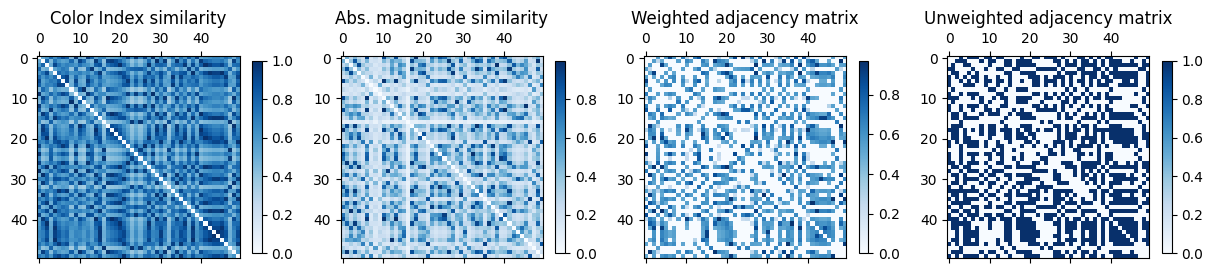

In [15]:
### Plot similarity matrices
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# Color index
p0 = axs[0].matshow(sim_ci[:50,:50], cmap=plt.cm.Blues);
axs[0].set_title("Color Index similarity");
fig.colorbar(p0, ax = axs[0], shrink = 0.5);
# Absoluted magnitude
p1 = axs[1].matshow(sim_am[:50,:50], cmap=plt.cm.Blues);
axs[1].set_title("Abs. magnitude similarity");
fig.colorbar(p1, ax = axs[1], shrink = 0.5);
# Weighted adjacency matrix
p2 = axs[2].matshow(sim_matrix[:50,:50], cmap=plt.cm.Blues);
axs[2].set_title("Weighted adjacency matrix");
fig.colorbar(p2, ax = axs[2], shrink = 0.5);
# Unweighted adjacency matrix
p3 = axs[3].matshow(sim_matrix_unweighted[:50,:50], cmap=plt.cm.Blues);
axs[3].set_title("Unweighted adjacency matrix");
fig.colorbar(p3, ax = axs[3], shrink = 0.5);

In [16]:
# Convert to sparse matrix
W = sparse.csr_matrix(sim_matrix)
assert(np.all(W.toarray().T == W.toarray()))

# Compute the Laplacian
d = np.array(np.sum(W, axis = 1))[:,0]
D = sparse.diags(d, format = "csr")
L = D - W

# Compute the symmetric normalized Laplacian
D_inv = scipy.linalg.pinv(D.toarray())
D_inv = sparse.csr_matrix(D_inv)
L_norm = sparse.csr_matrix.sqrt(D_inv) @ L @ sparse.csr_matrix.sqrt(D_inv)

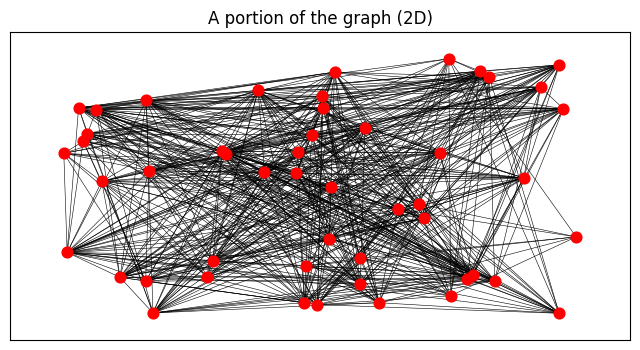

In [17]:
# Plot 2D graph (a portion)
plt.figure(figsize = (8, 4))
portion = 50
G = nx.from_scipy_sparse_array(W[:portion,: portion])
pos = nx.random_layout(G)
nx.draw_networkx(G, pos, node_size = 60, node_color = "red", width = 0.4, with_labels = False);
plt.title("A portion of the graph (2D)");

## 1) Spectral Clustering approach

We apply KMeans Clustering to stars, using a number $n_e$ of Laplacian eigenvectors as star features and imposing $n_c$ clusters. The eigenvectors are chosen as the first $n_e$ associated to the smallest eigenvalues.

Afterwards, the subtype of each item belonging to the validation set is inferred as the most frequent subtype in the assigned cluster.

In [18]:
evals, evecs = sparse.linalg.eigs(L_norm, k = 100, which = "SM")
eig = list(zip(evals.real, evecs.real.T))
evals, evecs = list(zip(*sorted(eig, key = lambda x: x[0])))
evecs = np.array(evecs).T

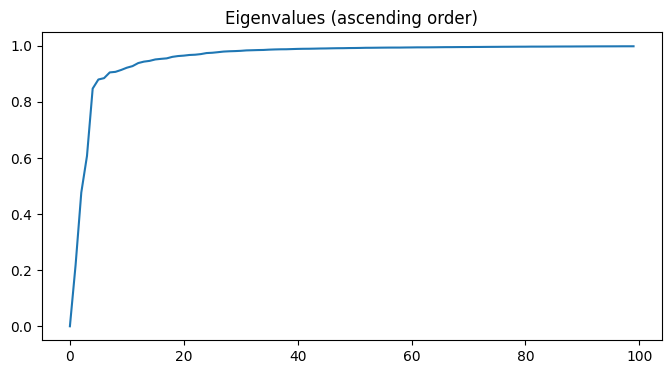

In [19]:
plt.figure(figsize = (8, 4))
plt.plot(evals);
plt.title("Eigenvalues (ascending order)");

In [20]:
# KMeans (ok with (10, 30) with threshold=0.5 and n=1000)
n_c = 20
n_e = 40
kmeans = KMeans(n_clusters = n_c, random_state=42).fit(evecs[:, :n_e])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
# Plot clusters
def color_fn():
  color = "#%06x" % random.randint(0, 0xFFFFFF)
  yield color
color_dict = {str(c):color_fn().__next__() for c in np.unique(kmeans.labels_)}
colors = [color_dict[str(c)] for c in kmeans.labels_]
plot_stars(colors, 2)

In [22]:
# Visualize one eigenvector
points = np.asarray(stars[["x", "y", "z"]])
vec = evecs[:, 10]
inf = vec.min()
sup = vec.max()
colors = [cm.hot(x)[0:3] for x in (vec - inf)/(sup-inf)]
plot_stars(colors, 2)

In [23]:
%%capture
# Update table of stars
stars["type"] = "train"
stars["cluster"] = kmeans.labels_
idx = pd.DataFrame(stars_val).index
stars.loc[idx, "type"] = "val"

# Assign subtype depending on most frequent subtype in that cluster
frequency = dict()
for j in range(n_c):
  cluster_stars = stars[stars["cluster"] == j]
  subtype = cluster_stars["subtype"].value_counts().index[0]
  frequency[f"{j}"] = subtype

def pred_subtype(row):
  s = frequency[str(row.iloc[-1])]
  return s

val_set = stars[stars["type"]=="val"]
val_set["pred_subtype"] = val_set.apply(pred_subtype, axis = 1)

In [24]:
val_set.head()

,index,id,proper,dist,absmag,spect,ci,x,y,z,subtype,type,cluster,pred_subtype
10,36907,36907,NaN,209.2050,0.217,A0V,0.043,-50.002486,111.735921,-169.651311,0,val,7,0
23,8818,8818,NaN,104.8218,-0.712,M4III SB,1.597,63.693781,34.455513,-75.786103,4,val,15,5
30,89145,89146,NaN,119.6172,4.401,G0,0.617,5.191169,-79.036589,-89.635618,0,val,8,5
39,62115,62116,NaN,217.3913,-0.036,K0II/III,1.140,-123.355594,-25.148122,-177.228516,0,val,10,0
54,44363,44363,NaN,117.0960,3.387,G0,0.470,-4.586622,4.433852,116.922098,0,val,11,5


In [25]:
# Compute accuracy
true = val_set["subtype"].astype(float)
pred = val_set["pred_subtype"].astype(float)
print(f"Accuracy: {sum(true == pred)/val_set.shape[0]*100:.5} %")
print(f"Accuracy (at most 1): {sum(abs(true - pred)<2)/val_set.shape[0]*100:.5} %")
print(f"Accuracy (at most 2): {sum(abs(true - pred)<3)/val_set.shape[0]*100:.5} %")
print(f"Accuracy (at most 3): {sum(abs(true - pred)<4)/val_set.shape[0]*100:.5} %")
print(f"Accuracy (at most 4): {sum(abs(true - pred)<5)/val_set.shape[0]*100:.5} %")

Accuracy: 33.0 %
Accuracy (at most 1): 43.0 %
Accuracy (at most 2): 63.0 %
Accuracy (at most 3): 74.0 %
Accuracy (at most 4): 79.0 %


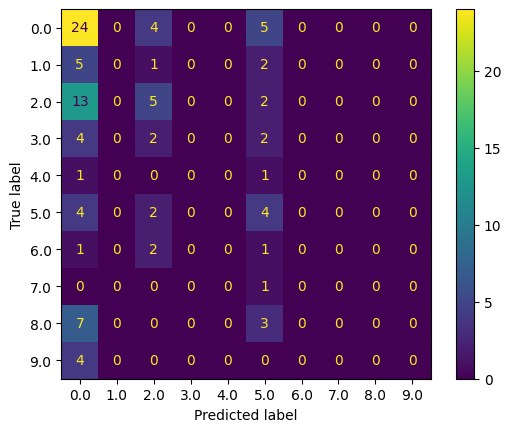

In [26]:
# Confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, pred);

## 2) Deep Neural Network approaches

### Prepare data

We decide to binarize the weighted adjacency matrix $W$, thus obtaining a binary matrix representing an undirected graph.

In [27]:
# Convert W to torch sparse tensor
W = sparse.csr_matrix(sim_matrix_unweighted)
coo = coo_matrix(W)
values = coo.data
indices = np.vstack((coo.row, coo.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape
adj = torch.sparse_coo_tensor(i, v, torch.Size(shape), dtype=torch.float)

# Features in form of torch tensor
features = torch.tensor(stars[["absmag", "ci"]].values, dtype=torch.float)
features.dtype

# Labels in form of torch tensor
labels = torch.tensor(stars[["subtype"]].values.astype(int))
labels = torch.squeeze(labels)

# Indexes
idx_train = torch.tensor(stars[stars["type"]=="train"].index)
idx_val = torch.tensor(idx)
print(idx_train.shape, idx_val.shape)

torch.Size([900]) torch.Size([100])


In [28]:
# Utility functions
def get_predictions(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    return correct

def accuracy(output, labels):
    correct = get_predictions(output, labels)
    correct = correct.sum()
    return correct / len(labels)


def plot_loss(losses):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(len(losses))),
        y=losses,
    ))

    fig.update_layout(
        title="Train loss",
        xaxis_title="Epoch",
        yaxis_title="Loss",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"
        )
    )
    return fig

def refresh_bar(bar, desc):
    bar.set_description(desc)
    bar.refresh()

### 2.1) Multilayer Perceptron

We train an MLP structure that ignores graph connectivities and only focuses on the input features for the prediction of the stellar subtype.

In [29]:
def mlp_accuracy(model):
    """
    Perfom a forward pass `y_pred = model(x)` and computes the accuracy
    between `y_pred` and `y_true`
    """
    model.eval()
    y_pred = model(features[idx_val])
    acc = accuracy(y_pred, labels[idx_val])
    print(f"Accuracy: {acc:.5}")
    return acc

In [30]:
# Model definition
mlp = nn.Sequential(nn.Linear(2, 500),
                    nn.ReLU(),
                    nn.Linear(500, 100),
                    nn.ReLU(),
                    nn.Linear(100, 10))

In [31]:
print("Loss before training")
_ = mlp_accuracy(mlp)

Loss before training
Accuracy: 0.05


In [32]:
opt = optim.Adam(mlp.parameters())

losses = []
mlp.train()

for epoch in trange(500):
    opt.zero_grad()
    output = mlp(features[idx_train])
    loss = F.cross_entropy(output, labels[idx_train])  # train only on the train samples
    loss.backward()
    opt.step()

    losses.append(loss.item())

plot_loss(losses)

100%|██████████| 500/500 [00:13<00:00, 38.19it/s]


In [33]:
# Compute accuracy
true = stars_val["subtype"].astype(float)
pred = mlp(features)[idx_val]
pred = np.array(pred.max(1)[1], dtype=float)
print(f"Accuracy: {sum(true == pred)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 1): {sum(abs(true - pred)<2)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 2): {sum(abs(true - pred)<3)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 3): {sum(abs(true - pred)<4)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 4): {sum(abs(true - pred)<5)/stars_val.shape[0]*100:.5} %")

Accuracy: 27.0 %
Accuracy (at most 1): 36.0 %
Accuracy (at most 2): 57.0 %
Accuracy (at most 3): 71.0 %
Accuracy (at most 4): 75.0 %


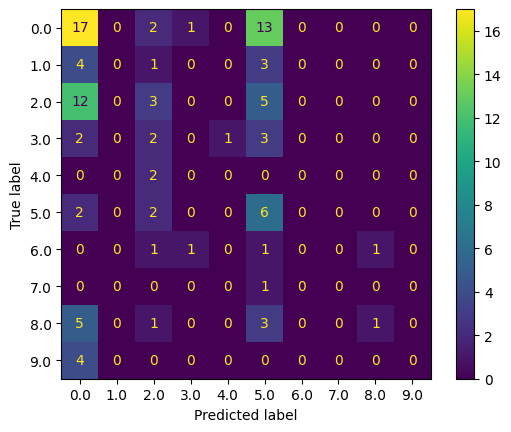

In [34]:
# Confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, pred);

### 2.2) Graph Convolutional Network

We train a simple GCN model that, differing from MLP, takes into account graph connectivity by leveraging convolutional layers.

In [35]:
class GraphConvolution(Module):

    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

In [36]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return x

In [37]:
def gcn_accuracy(model):
    """
    Perfom a forward pass `y_pred = model(x)` and computes the accuracy
    between `y_pred` and `y_true`.

    It is particuarly tricky to perform batching in GCN.
    As you can see, here the forward pass is performed on the whole graph
    """
    model.eval()
    y_pred = model(features, adj)
    acc = accuracy(y_pred[idx_val], labels[idx_val])
    print(f"Accuracy: {acc:.5}")
    return acc

In [38]:
nhid = 20   #OK with 20 and trange(300) and stars=1000
gcn = GCN(2, nhid, 10)

print("Loss before training")
_ = gcn_accuracy(gcn)

Loss before training
Accuracy: 0.1


In [39]:
opt = optim.Adam(gcn.parameters())

losses = []
gcn.train()

for epoch in trange(300):
    opt.zero_grad()
    # Compute all outputs, even for the nodes in the test set
    output = gcn(features, adj)
    # Train only on the train samples
    loss = F.cross_entropy(output[idx_train], labels[idx_train])
    loss.backward()
    opt.step()

    losses.append(loss.item())

plot_loss(losses)

100%|██████████| 300/300 [00:25<00:00, 11.75it/s]


In [40]:
# Compute accuracy
true = stars_val["subtype"].astype(float)
pred = gcn(features, adj)[idx_val]
pred = np.array(pred.max(1)[1], dtype=float)
print(f"Accuracy: {sum(true == pred)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 1): {sum(abs(true - pred)<2)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 2): {sum(abs(true - pred)<3)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 3): {sum(abs(true - pred)<4)/stars_val.shape[0]*100:.5} %")
print(f"Accuracy (at most 4): {sum(abs(true - pred)<5)/stars_val.shape[0]*100:.5} %")

Accuracy: 17.0 %
Accuracy (at most 1): 34.0 %
Accuracy (at most 2): 54.0 %
Accuracy (at most 3): 69.0 %
Accuracy (at most 4): 76.0 %


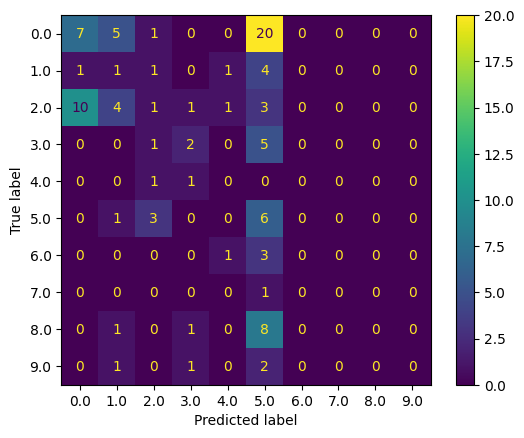

In [41]:
# Confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(true, pred);

## Discussion and Conclusion

Overall, Spectral Clustering performs the best, although the accuracy is not much above the random assignment (10%). Of course, by increasing the tolerance range for its computation, accuracy increases. It is possible that these measures are more interesting to astronomers than a precise accuracy.

In addition, KMeans Spectral Clustering interestingly seems to identify concentric spheres round the Sun, expliciting a sort of **geometric structure** in our neighborhood stars, **not depending on coordinates**.

As future development in this way, we recommend experimenting with different number of clusters, eigenvectors and similarity matrices. Moreover, it may relevant to add features such as Cartesian velocities and coordinates, as well as spectral lines of stars.

Deep nets do not improve accuracy. As future improvement, a deeper network may increase accuracy, especially with more data. Edge features may be added, too, as well as global graph features.









Finally, the two approaches may be joined together, for instance by using cluster classification as additional feature to GCN.